In [405]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
from tqdm import *
import seaborn as sns
import pymc3 as pm
import pylab as pb
sns.set_style('whitegrid')
%matplotlib inline
from scipy import stats
from sklearn.metrics import accuracy_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [212]:
df = pd.read_csv('Person_Hourly_preds_with_DarkSky_data.csv')
df.head(2)

# calculate day length in hours
df['daily__sunriseTime'] = pd.to_datetime(df['daily__sunriseTime'], unit='s')
df['daily__sunsetTime'] = pd.to_datetime(df['daily__sunsetTime'], unit='s')
df['day_length'] = (df['daily__sunsetTime'] - df['daily__sunriseTime']).astype('timedelta64[h]')

use_cols = ['dt', 'object_count', 'hour', 'week_in_month', 
            'month', 'day_of_week', 'is_weekend', 
            'cur__precipIntensity', 'cur__precipProbability', 
            'cur__temperature', 'cur__apparentTemperature',
            'cur__windSpeed', 'cur__windGust', 'cur__cloudCover', 
            'day_length', 'daily__temperatureHigh', 
            'daily__temperatureLow']

df = df[use_cols].copy()

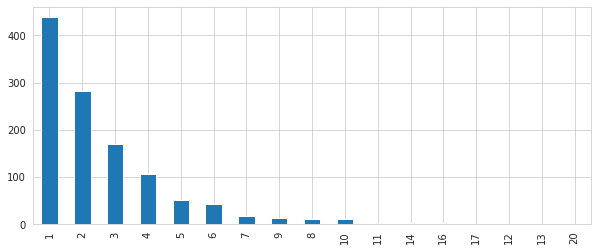

In [213]:
df[df.object_count != 0].object_count.value_counts().plot(figsize=(10, 4), kind='bar');

In [214]:
df['object_count'].mean()

1.1607828089025327

In [215]:
df['object_count'].std()

1.9470566400902949

In [216]:
df.groupby('hour')['object_count'].mean()

hour
0     0.018519
1     0.009259
2     0.027778
3     0.000000
4     0.000000
5     0.000000
6     0.509259
7     0.844037
8     0.899083
9     2.678899
10    1.486239
11    2.568807
12    2.027523
13    2.633028
14    2.229358
15    2.064220
16    2.321101
17    2.311927
18    2.000000
19    1.651376
20    0.816514
21    0.509259
22    0.101852
23    0.055556
Name: object_count, dtype: float64

In [217]:
df.groupby('hour')['object_count'].std()

hour
0     0.135445
1     0.096225
2     0.165102
3     0.000000
4     0.000000
5     0.000000
6     1.072122
7     1.115333
8     1.088194
9     1.990164
10    1.878803
11    2.229296
12    2.258559
13    2.551908
14    2.110964
15    2.073980
16    2.376119
17    3.140822
18    2.325383
19    2.510630
20    1.292178
21    1.218973
22    0.360161
23    0.230129
Name: object_count, dtype: float64

In [218]:
use_cols = ['hour', 'week_in_month', 'day_of_week', 'is_weekend',
           'cur__precipIntensity', 'cur__precipProbability', 'cur__temperature',
           'cur__windSpeed', 'cur__windGust', 'cur__cloudCover', 'day_length',
           'daily__temperatureHigh', 'daily__temperatureLow', 'object_count']
X = df[use_cols].values
Y = df['object_count'].values[:, None]

In [219]:
Y.std()

1.9466830323654527

In [220]:
Y.mean()

1.1607828089025327

In [13]:
df[use_cols].head(2)

,hour,week_in_month,day_of_week,is_weekend,cur__precipIntensity,cur__precipProbability,cur__temperature,cur__windSpeed,cur__windGust,cur__cloudCover,day_length,daily__temperatureHigh,daily__temperatureLow,object_count
0,7,2,0,0,0.01,0.08,11.30,26.13,43.99,0.43,13.0,16.6,7.01,2
1,8,2,0,0,0.00,0.00,11.37,26.73,43.38,0.26,13.0,16.6,7.01,1


### PyMC3 simple naive Poisson

In [17]:
with pm.Model() as constant_count_model:
    
    # prior
    lambda_prior = pm.Uniform('lambda_prior', 0, 20)

    # likelihood
    Y_obs = pm.Poisson('Y_obs', mu=lambda_prior, observed=Y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 6 jobs)
NUTS: [lambda_prior]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 3799.80draws/s]


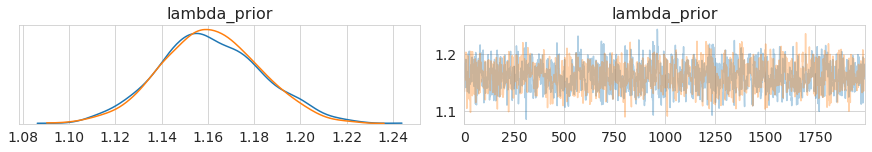

In [18]:
with constant_count_model:
    trace = pm.sample(2000, cores=6, chains=2, tune=1000)
    pm.traceplot(trace)
    plt.show()

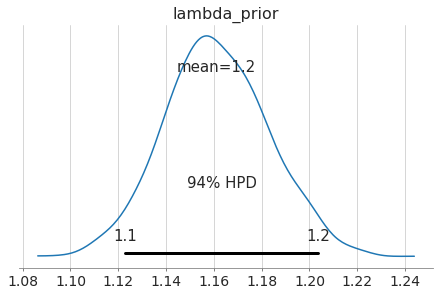

In [19]:
pm.plot_posterior(trace);

In [20]:
df.head(2)

,dt,object_count,hour,week_in_month,month,day_of_week,is_weekend,cur__precipIntensity,cur__precipProbability,cur__temperature,cur__apparentTemperature,cur__windSpeed,cur__windGust,cur__cloudCover,day_length,daily__temperatureHigh,daily__temperatureLow
0,2019-09-09 06:30:00,2,7,2,9,0,0,0.01,0.08,11.30,11.30,26.13,43.99,0.43,13.0,16.6,7.01
1,2019-09-09 07:30:00,1,8,2,9,0,0,0.00,0.00,11.37,11.37,26.73,43.38,0.26,13.0,16.6,7.01


In [221]:
X = df[['hour', 'week_in_month', 'month', 'day_of_week', 'is_weekend', 
        'cur__precipIntensity', 'cur__precipProbability', 'cur__temperature',
        'cur__windSpeed', 'day_length']].values
Y = df['object_count'].values[:, None]

In [222]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.33, random_state=42)

In [223]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scalled = scaler.transform(X_train)

### Poisson model

In [562]:
# https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [737]:
df = pd.read_csv('Person_Hourly_preds_with_DarkSky_data.csv')
df.head(2)

,time_interval,object_count,hour,week,week_in_month,month,day_of_week,is_weekend,time_interval-30min,ts,dt,cur__summary,cur__precipIntensity,cur__precipProbability,cur__precipType,cur__temperature,cur__apparentTemperature,cur__humidity,cur__windSpeed,cur__windGust,cur__windBearing,cur__cloudCover,cur__uvIndex,cur__visibility,daily__summary,daily__sunriseTime,daily__sunsetTime,daily__temperatureHigh,daily__temperatureLow
0,2019-09-09 07:00:00,2,7,37,2,9,0,0,2019-09-09 06:30:00,1568007000,2019-09-09 06:30:00,Partly Cloudy,0.01,0.08,rain,11.30,11.30,0.89,26.13,43.99,329,0.43,0,16.093,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01
1,2019-09-09 08:00:00,1,8,37,2,9,0,0,2019-09-09 07:30:00,1568010600,2019-09-09 07:30:00,Clear,0.00,0.00,rain,11.37,11.37,0.86,26.73,43.38,311,0.26,0,16.093,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01


In [738]:
# remove night hours, as we know these are 99% 0's
df = df.loc[(df['hour'] > 4) & (df['hour'] < 23)].copy()

### Remove outliers

In [739]:
df['object_count'].value_counts()

0     816
1     427
2     283
3     170
4     107
5      51
6      42
7      18
9      13
8      11
10     10
11      2
14      2
16      2
17      1
12      1
13      1
20      1
Name: object_count, dtype: int64

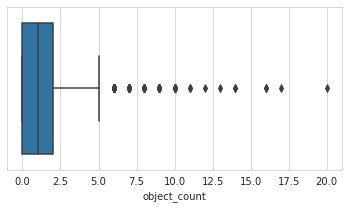

In [740]:
# Remove outliers
import seaborn as sns
rcParams['figure.figsize'] = 6, 3
sns.boxplot(x=df['object_count']);
plt.show()

In [741]:
def subset_by_iqr(df, column, whisker_width=1.5):
    """Remove outliers from a dataframe by column, including optional 
       whiskers, removing rows for which the column value are 
       less than Q1-1.5IQR or greater than Q3+1.5IQR.
    Args:
        df (`:obj:pd.DataFrame`): A pandas dataframe to subset
        column (str): Name of the column to calculate the subset from.
        whisker_width (float): Optional, loosen the IQR filter by a
                               factor of `whisker_width` * IQR.
    Returns:
        (`:obj:pd.DataFrame`): Filtered dataframe
    """
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]                                                     

# Example for whiskers = 1.5, as requested by the OP
df = subset_by_iqr(df, 'object_count', whisker_width=1.5)

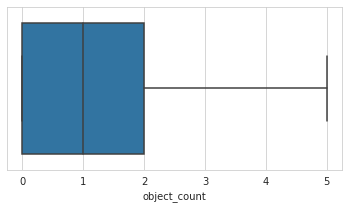

In [742]:
rcParams['figure.figsize'] = 6, 3
sns.boxplot(x=df['object_count']);
plt.show()

In [743]:
df.shape

(1854, 29)

In [744]:
df['object_count'].value_counts()

0    816
1    427
2    283
3    170
4    107
5     51
Name: object_count, dtype: int64

In [745]:
# calculate day length in hours
df['daily__sunriseTime'] = pd.to_datetime(df['daily__sunriseTime'], unit='s')
df['daily__sunsetTime'] = pd.to_datetime(df['daily__sunsetTime'], unit='s')
df['day_length'] = (df['daily__sunsetTime'] - df['daily__sunriseTime']).astype('timedelta64[h]')

use_cols = ['hour', 'month', 'day_of_week', 'is_weekend',
           'cur__precipIntensity', 'cur__precipProbability', 'cur__temperature',
           'cur__windSpeed', 'cur__windGust', 'cur__cloudCover', 'day_length',
           'daily__temperatureHigh', 'daily__temperatureLow', 'object_count']

df = df[use_cols]

In [746]:
all_cols = ['hour', 'month', 'day_of_week', 'is_weekend', 'cur__precipIntensity', 
            'cur__precipProbability', 'cur__temperature', 'cur__windSpeed', 'cur__windGust', 
            'cur__cloudCover', 'day_length', 'daily__temperatureHigh', 'daily__temperatureLow']

### Find features correlated with object counts

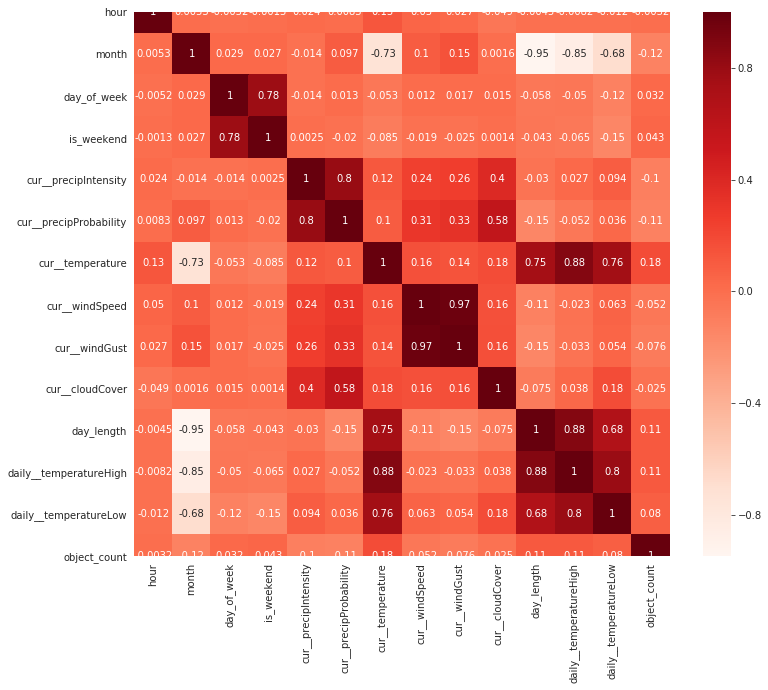

In [747]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [748]:
cor_target = abs(cor["object_count"])
cor_target

hour                      0.003158
month                     0.121976
day_of_week               0.031841
is_weekend                0.042735
cur__precipIntensity      0.101962
cur__precipProbability    0.114269
cur__temperature          0.184526
cur__windSpeed            0.051519
cur__windGust             0.076208
cur__cloudCover           0.024807
day_length                0.114454
daily__temperatureHigh    0.113352
daily__temperatureLow     0.079527
object_count              1.000000
Name: object_count, dtype: float64

In [749]:
# Selecting higher correlated features
relevant_features = cor_target[cor_target>0.05]
relevant_features

month                     0.121976
cur__precipIntensity      0.101962
cur__precipProbability    0.114269
cur__temperature          0.184526
cur__windSpeed            0.051519
cur__windGust             0.076208
day_length                0.114454
daily__temperatureHigh    0.113352
daily__temperatureLow     0.079527
object_count              1.000000
Name: object_count, dtype: float64

In [750]:
# Remove correlated features
print(df[["cur__precipIntensity","cur__precipProbability"]].corr())

                        cur__precipIntensity  cur__precipProbability
cur__precipIntensity                1.000000                0.803213
cur__precipProbability              0.803213                1.000000


In [751]:
print(df[["cur__temperature","day_length"]].corr())

                  cur__temperature  day_length
cur__temperature           1.00000     0.75136
day_length                 0.75136     1.00000


In [752]:
print(df[["daily__temperatureHigh","daily__temperatureLow"]].corr())

                        daily__temperatureHigh  daily__temperatureLow
daily__temperatureHigh                1.000000               0.801853
daily__temperatureLow                 0.801853               1.000000


In [753]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]

expr = """object_count ~ hour + month + cur__precipIntensity + cur__precipProbability + cur__temperature + cur__windGust + day_length + daily__temperatureHigh + daily__temperatureLow"""
print('Expr: ', expr)

#Set up the X and y matrices
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

Expr:  object_count ~ hour + month + cur__precipIntensity + cur__precipProbability + cur__temperature + cur__windGust + day_length + daily__temperatureHigh + daily__temperatureLow


In [621]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#Print the training summary.
print(poisson_training_results.summary())

Expr:  object_count ~ hour + month + cur__precipIntensity + cur__precipProbability + cur__temperature + cur__windGust + day_length + daily__temperatureHigh + daily__temperatureLow
                 Generalized Linear Model Regression Results                  
Dep. Variable:           object_count   No. Observations:                 1482
Model:                            GLM   Df Residuals:                     1472
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2198.9
Date:                Fri, 17 Jan 2020   Deviance:                       2298.7
Time:                        21:40:33   Pearson chi2:                 2.20e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                             c

In [ ]:

#Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(X_test)

predictions_summary_frame = poisson_predictions.summary_frame()
#print(predictions_summary_frame[:10])

predicted_ci_lower = predictions_summary_frame['mean_ci_lower']
predicted_ci_upper = predictions_summary_frame['mean_ci_upper']

predicted_counts = predictions_summary_frame['mean']
actual_counts = y_test['object_count']

In [593]:
thresh = 0.4
predicted_counts_rounded = round(predicted_counts - thresh + 0.5).copy()

print(predicted_counts[:5].tolist())
print(predicted_counts_rounded[:5].tolist())
print(actual_counts[:5].tolist())

print('ACC:', accuracy_score(actual_counts, predicted_counts_rounded))

[0.8202332834462853, 0.8954761073769434, 1.215564314133985, 1.5850791276233598, 0.8730603969576066]
[1.0, 1.0, 1.0, 2.0, 1.0]
[2.0, 3.0, 0.0, 5.0, 0.0]
ACC: 0.22857142857142856


In [594]:
results = pd.DataFrame({'pred': predicted_counts, 'pred_rounded': predicted_counts_rounded, 'actual': actual_counts})
results['diff'] = results['actual'] - results['pred_rounded']
results['diff_abs'] = results['diff'].abs()
results['zero'] = 0
#results['pred_rounded'].value_counts()

In [595]:
print('ACC:', accuracy_score(results['actual'], results['zero']))

ACC: 0.4595238095238095


In [596]:
results.head()

,pred,pred_rounded,actual,diff,diff_abs,zero
0,0.820233,1.0,2.0,1.0,1.0,0
2,0.895476,1.0,3.0,2.0,2.0,0
4,1.215564,1.0,0.0,-1.0,1.0,0
11,1.585079,2.0,5.0,3.0,3.0,0
15,0.873060,1.0,0.0,-1.0,1.0,0


In [597]:
# TODO: Calculate accuracy if object will show or not within given time
results['actual_binary'] = (results['actual'] != 0).astype(int)
results['pred_binary'] = (results['pred_rounded'] != 0).astype(int)
results.head()

,pred,pred_rounded,actual,diff,diff_abs,zero,actual_binary,pred_binary
0,0.820233,1.0,2.0,1.0,1.0,0,1,1
2,0.895476,1.0,3.0,2.0,2.0,0,1,1
4,1.215564,1.0,0.0,-1.0,1.0,0,0,1
11,1.585079,2.0,5.0,3.0,3.0,0,1,1
15,0.873060,1.0,0.0,-1.0,1.0,0,0,1


In [598]:
print('ACC:', accuracy_score(results['actual_binary'], results['pred_binary']))

ACC: 0.5404761904761904


In [599]:
results['actual'].value_counts()

0.0    193
1.0    100
2.0     59
3.0     35
4.0     25
5.0      8
Name: actual, dtype: int64

In [600]:
results['pred_rounded'].value_counts()

1.0    304
2.0    110
3.0      6
Name: pred_rounded, dtype: int64

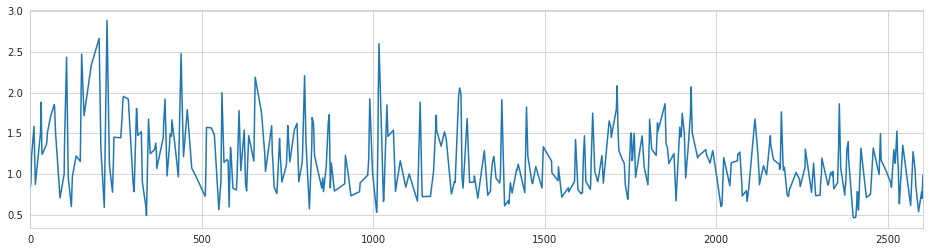

In [601]:
results['pred'].plot();

### Observation

Model has not learned any zeros, where there should be majority of those

In [602]:
from sklearn.metrics import confusion_matrix
confusion_matrix(predicted_counts_rounded, actual_counts)

array([[  0,   0,   0,   0,   0,   0],
       [164,  68,  30,  23,  16,   3],
       [ 28,  30,  28,  12,   9,   3],
       [  1,   2,   1,   0,   0,   2],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0]])

In [603]:
pd.crosstab(actual_counts, predicted_counts_rounded, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1.0,2.0,3.0,All
True,,,,
0.0,164,28,1,193
1.0,68,30,2,100
2.0,30,28,1,59
3.0,23,12,0,35
4.0,16,9,0,25
5.0,3,3,2,8
All,304,110,6,420


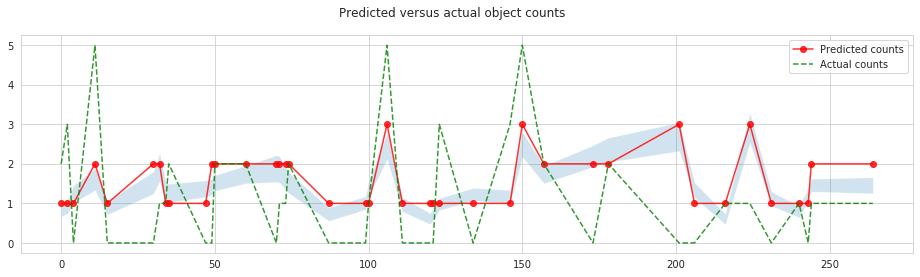

************************************************************************************************************************


In [604]:
# Plot the predicted counts versus the actual counts for the test data.
# TODO: Plot uncertainty as well
from pylab import rcParams
rcParams['figure.figsize'] = 16, 4
fig = plt.figure()
fig.suptitle('Predicted versus actual object counts')
predicted, = plt.plot(X_test.index[:40], predicted_counts_rounded[:40], 'ro-', label='Predicted counts', alpha=0.8)
actual, = plt.plot(X_test.index[:40], actual_counts[:40], 'g--', label='Actual counts', alpha=0.8)

plt.fill_between(X_test.index[:40], predicted_ci_lower[:40], predicted_ci_upper[:40], alpha=0.2, 
                 label='Prediction uncertainty')

plt.legend(handles=[predicted, actual])
plt.show();
print('*' * 120)

### Conclusion

Model is not any better than setting all values to zero. The accuracy of the "Zero" model is actually higher than the Poisson model. Perhaps different model is required or predicting objects in the 60 minutes time window is not possible and it should be extended to 2 hours.

### Random Forest

In [836]:
df.head()

,hour,month,day_of_week,is_weekend,cur__precipIntensity,cur__precipProbability,cur__temperature,cur__windSpeed,cur__windGust,cur__cloudCover,day_length,daily__temperatureHigh,daily__temperatureLow,object_count
0,7,9,0,0,0.0100,0.08,11.30,26.13,43.99,0.43,13.0,16.6,7.01,2
1,8,9,0,0,0.0000,0.00,11.37,26.73,43.38,0.26,13.0,16.6,7.01,1
2,9,9,0,0,0.0052,0.07,11.92,28.37,44.96,0.26,13.0,16.6,7.01,3
3,10,9,0,0,0.0129,0.15,12.93,29.81,46.10,0.27,13.0,16.6,7.01,0
4,11,9,0,0,0.0143,0.13,13.98,30.79,46.50,0.24,13.0,16.6,7.01,0


In [842]:
cols = 'hour + month + cur__precipIntensity + cur__precipProbability + cur__temperature + cur__windGust + day_length + daily__temperatureHigh + daily__temperatureLow'.split(' + ')
X = df[cols]
y = df['object_count']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [850]:
np.floor([0.1, 0.9, 1.3, 1.9, 2.0])

array([0., 0., 1., 1., 2.])

In [934]:
from sklearn.ensemble import RandomForestRegressor

# Create the model with 100 trees
model = RandomForestRegressor(n_estimators=400)

# Fit on training data
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_rounded = np.floor(y_pred)

results = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'y_pred_rounded': y_pred_rounded})
results['zeros'] = 0
results['binary_y_test'] = (results['y_test'] != 0).astype(int)
results['binary_y_pred'] = (results['y_pred_rounded'] != 0).astype(int)
results[['binary_y_test', 'binary_y_pred']].head()

print('OVERALL ACC:', accuracy_score(y_test, y_pred_rounded))
print('BINARY ACC:', accuracy_score(results['binary_y_test'], results['binary_y_pred']))

OVERALL ACC: 0.4820261437908497
BINARY ACC: 0.7156862745098039


In [935]:
print(model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [936]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [937]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [938]:
# rf_random.best_params_

In [933]:
model = rf_random.best_estimator_
y_pred = model.predict(X_test)
y_pred_rounded = np.floor(y_pred)

results = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'y_pred_rounded': y_pred_rounded})
results['zeros'] = 0
results['binary_y_test'] = (results['y_test'] != 0).astype(int)
results['binary_y_pred'] = (results['y_pred_rounded'] != 0).astype(int)
results[['binary_y_test', 'binary_y_pred']].head()

print('OVERALL ACC:', accuracy_score(y_test, y_pred_rounded))
print('BINARY ACC:', accuracy_score(results['binary_y_test'], results['binary_y_pred']))

OVERALL ACC: 0.46405228758169936
BINARY ACC: 0.7238562091503268


In [902]:
X_test.head(2)

,hour,month,cur__precipIntensity,cur__precipProbability,cur__temperature,cur__windGust,day_length,daily__temperatureHigh,daily__temperatureLow
338,9,9,1.5398,0.77,14.65,52.49,12.0,18.07,13.90
655,14,10,0.0000,0.00,15.26,16.15,11.0,15.68,11.92


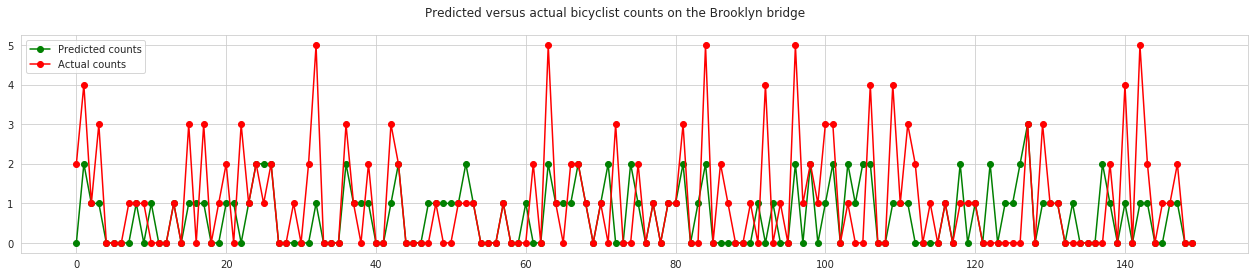

In [939]:
n_observations = 150
x_axis = [i for i in range(n_observations)]

rcParams['figure.figsize'] = 22, 4
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(x_axis, y_pred_rounded[:n_observations], 'go-', label='Predicted counts')
actual, = plt.plot(x_axis, y_test[:n_observations], 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [889]:
#X_test.head()

In [893]:
results['y_test'].value_counts()

0    269
1    148
2     95
3     54
4     26
5     20
Name: y_test, dtype: int64

In [891]:
#results['y_pred_rounded'].value_counts()

In [892]:
pd.crosstab(results['y_test'], results['y_pred_rounded'], rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,2.0,3.0,All
True,,,,,
0,182,70,17,0,269
1,43,87,15,3,148
2,24,41,28,2,95
3,8,24,18,4,54
4,5,10,10,1,26
5,2,5,12,1,20
All,264,237,100,11,612


### Conclusion:

This model is not bad really. I have proven that is has more value than the dummy Zero's model and it can potentially achieve a further improvement by nomalising the features using a Scaler.

### Negative Binomial Regression

https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

In [658]:
df.head(2)

,hour,month,day_of_week,is_weekend,cur__precipIntensity,cur__precipProbability,cur__temperature,cur__windSpeed,cur__windGust,cur__cloudCover,day_length,daily__temperatureHigh,daily__temperatureLow,object_count
0,7,9,0,0,0.01,0.08,11.30,26.13,43.99,0.43,13.0,16.6,7.01,2
1,8,9,0,0,0.00,0.00,11.37,26.73,43.38,0.26,13.0,16.6,7.01,1


In [674]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask].copy()
df_test = df[~mask].copy()

In [675]:
df_train.shape

(1488, 14)

In [676]:
df_test.shape

(366, 14)

In [677]:
expr = """object_count ~ hour + month + cur__precipIntensity + cur__precipProbability + cur__temperature + cur__windGust + day_length + daily__temperatureHigh + daily__temperatureLow"""

#Set up the X and y matrices
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [678]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#Print the training summary.
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           object_count   No. Observations:                 1488
Model:                            GLM   Df Residuals:                     1478
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2223.8
Date:                Sun, 19 Jan 2020   Deviance:                       2337.0
Time:                        19:43:49   Pearson chi2:                 2.25e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

In [679]:
df_train.shape

(1488, 14)

In [680]:
print(poisson_training_results.mu)
print(len(poisson_training_results.mu))

[0.91328726 0.95842444 0.98897692 ... 0.95990176 1.10275008 1.17339335]
1488


In [681]:
df_train['Poisson_lambda'] = poisson_training_results.mu
df_train.head(2)

,hour,month,day_of_week,is_weekend,cur__precipIntensity,cur__precipProbability,cur__temperature,cur__windSpeed,cur__windGust,cur__cloudCover,day_length,daily__temperatureHigh,daily__temperatureLow,object_count,Poisson_lambda
0,7,9,0,0,0.01,0.08,11.30,26.13,43.99,0.43,13.0,16.6,7.01,2,0.913287
1,8,9,0,0,0.00,0.00,11.37,26.73,43.38,0.26,13.0,16.6,7.01,1,0.958424


In [682]:
# improve existing formula by vectorizing the operation
df_train['AUX_OLS_DEP'] = ((np.power(df_train['object_count'] - df_train['Poisson_lambda'], 2)) 
                           - df_train['object_count']) / df_train['Poisson_lambda']
df_train.head(2)

,hour,month,day_of_week,is_weekend,cur__precipIntensity,cur__precipProbability,cur__temperature,cur__windSpeed,cur__windGust,cur__cloudCover,day_length,daily__temperatureHigh,daily__temperatureLow,object_count,Poisson_lambda,AUX_OLS_DEP
0,7,9,0,0,0.01,0.08,11.30,26.13,43.99,0.43,13.0,16.6,7.01,2,0.913287,-0.896821
1,8,9,0,0,0.00,0.00,11.37,26.73,43.38,0.26,13.0,16.6,7.01,1,0.958424,-1.041576


In [683]:
import statsmodels.formula.api as smf

In [684]:
ols_expr = """AUX_OLS_DEP ~ Poisson_lambda - 1"""

In [685]:
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

In [690]:
print(aux_olsr_results.params)

Poisson_lambda    0.340953
dtype: float64


In [687]:
print(aux_olsr_results.tvalues)

Poisson_lambda    7.458882
dtype: float64


In [688]:
X_train.head(2)

,Intercept,hour,month,cur__precipIntensity,cur__precipProbability,cur__temperature,cur__windGust,day_length,daily__temperatureHigh,daily__temperatureLow
0,1.0,7.0,9.0,0.01,0.08,11.30,43.99,13.0,16.6,7.01
1,1.0,8.0,9.0,0.00,0.00,11.37,43.38,13.0,16.6,7.01


In [691]:
nb2_training_results = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [692]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           object_count   No. Observations:                 1488
Model:                            GLM   Df Residuals:                     1478
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2163.3
Date:                Tue, 21 Jan 2020   Deviance:                       1769.3
Time:                        19:36:56   Pearson chi2:                 1.64e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

In [693]:
nb2_preds = nb2_training_results.get_prediction(X_test)

In [695]:
predictions_summary_frame = nb2_preds.summary_frame()
print(predictions_summary_frame[:5])

        mean   mean_se  mean_ci_lower  mean_ci_upper
3   1.133158  0.123891       0.914590       1.403960
14  1.153187  0.124686       0.932966       1.425391
26  0.656559  0.095817       0.493231       0.873971
37  1.161109  0.133705       0.926520       1.455093
52  1.672942  0.122210       1.449773       1.930464


In [735]:
predicted_counts = predictions_summary_frame['mean']
actual_counts = y_test['object_count']

thresh = 1.3
predicted_counts_rounded = round(predicted_counts - thresh + 0.5).copy()

#print(predicted_counts[:5].tolist())
#print(predicted_counts_rounded[:5].tolist())
#print(actual_counts[:5].tolist())

print('ACC:', round(accuracy_score(actual_counts, predicted_counts_rounded), 3))

pd.crosstab(actual_counts, predicted_counts_rounded, rownames=['True'], colnames=['Predicted'], margins=True)

ACC: 0.448


Predicted,0.0,1.0,2.0,All
True,,,,
0.0,134,27,2,163
1.0,45,30,4,79
2.0,33,23,0,56
3.0,19,17,0,36
4.0,9,13,0,22
5.0,3,6,1,10
All,243,116,7,366


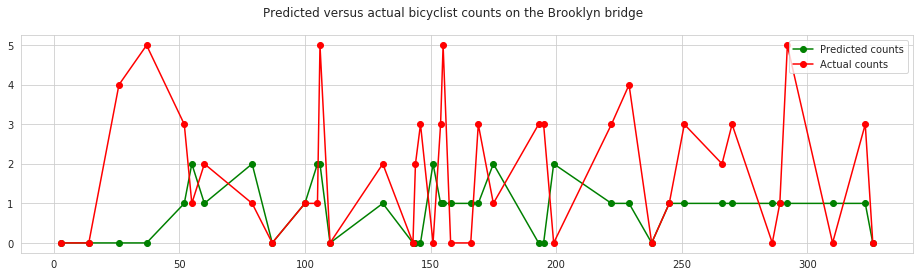

In [736]:
rcParams['figure.figsize'] = 16, 4
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index[:40], predicted_counts_rounded[:40], 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index[:40], actual_counts[:40], 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

### Zero inflated Poisson

In [798]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask].copy()
df_test = df[~mask].copy()

In [799]:
expr = """object_count ~ hour + month + cur__precipIntensity + cur__precipProbability + cur__temperature + cur__windGust + day_length + daily__temperatureHigh + daily__temperatureLow"""

#Set up the X and y matrices
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [802]:
from statsmodels.discrete.count_model import ZeroInflatedPoisson
zip_model_results = ZeroInflatedPoisson(y_train, X_train).fit(maxiter=200)
preds = zip_model_results.predict(X_test, exog_infl=np.ones((len(X_test),1)))

Optimization terminated successfully.
         Current function value: 1.443454
         Iterations: 40
         Function evaluations: 47
         Gradient evaluations: 47


 /home/adamsky/anaconda3/envs/yolov3-tf2-gpu/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


In [835]:
actual_counts = y_test['object_count']

#thresh = 0.51
#predicted_counts_rounded = round(preds - thresh + 0.5).copy()

predicted_counts_rounded = np.floor(preds)

print(preds[:5].tolist())
print(predicted_counts_rounded[:5].tolist())
print(actual_counts[:5].tolist())

print('ACC:', round(accuracy_score(actual_counts, predicted_counts_rounded), 3))

pd.crosstab(actual_counts, predicted_counts_rounded, rownames=['True'], colnames=['Predicted'], margins=True)

[0.9013390978632015, 0.9617735080488448, 1.6890688006244503, 1.4829222980887369, 0.7322763983519173]
[0.0, 0.0, 1.0, 1.0, 0.0]
[2.0, 3.0, 0.0, 5.0, 4.0]
ACC: 0.364


Predicted,0.0,1.0,2.0,All
True,,,,
0.0,89,69,1,159
1.0,25,42,5,72
2.0,15,36,1,52
3.0,10,38,0,48
4.0,3,18,0,21
5.0,1,6,4,11
All,143,209,11,363


### NN

Review this article in detail: https://github.com/gokceneraslan/neuralnet_countmodels

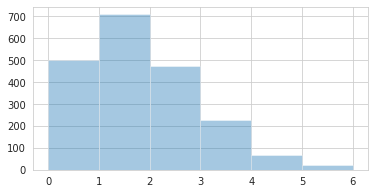

In [945]:
poisson_mean = 1.4
poisson_numsample = 2000

# Poisson sampling is still not implemented in TF
samples = np.random.poisson(poisson_mean, poisson_numsample)
rcParams['figure.figsize'] = 6, 3
_ = sns.distplot(samples, kde=False, bins=range(max(samples)))

### PyMC3 more advanced Poisson